# CFPB Mini Project

## This notebook answers the question: What the heck happened in 2020? (Yes, COVID)

#### Data: complaints submitted to the Consumer Finance Protection Bureau


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'figure.figsize': (10, 8)}) # set font and plot size to be larger

In [2]:
# read in the data.
# this is a randomly sampled half of the complaints data from the CFPB website:
# https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data
# Additionally, the column "Consumer complaint narrative" has been dropped.
df = pd.read_csv('./data/complaints_random_half.csv', index_col="Complaint ID")

/Users/gracezhang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#create columns for year, month, and day
df['date_temp'] = pd.to_datetime(df['Date sent to company'])
df['day'] = df['date_temp'].dt.strftime('%d').apply(lambda x: int(x))
df['month'] = df['date_temp'].dt.strftime('%m').apply(lambda x: int(x))
df['year'] = df['date_temp'].dt.strftime('%Y').apply(lambda x: int(x))
df['month_day'] = df['date_temp'].dt.strftime('%m-%d')
df['day_of_year'] = df['date_temp'].dt.strftime('%j').apply(lambda x: int(x))

df['day'].apply(lambda x: int(x))
df.drop(['date_temp'], axis = 1, inplace=True)

# Notice there is a sudden spike in the number of complaints in 2020

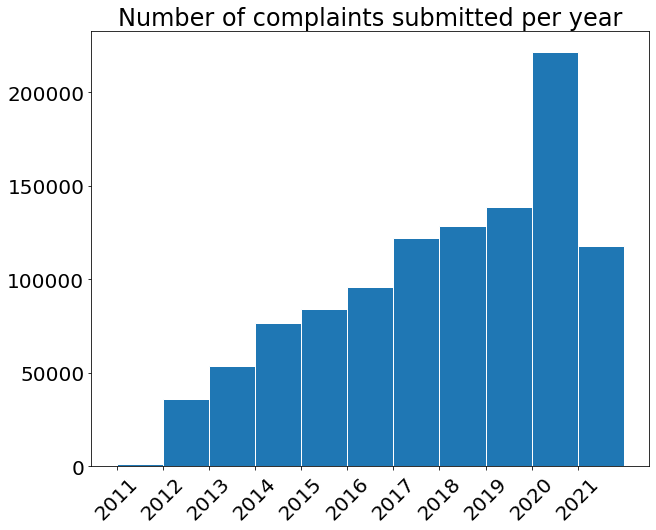

In [4]:
plt.hist([df['year'].astype('int64')], bins=list(range(2011,2023,1)), edgecolor='white')
plt.title("Number of complaints submitted per year")
plt.xticks(list(range(2011,2022,1)), rotation=45)  # Set text labels and properties.
plt.show()

(Data for 2021 only goes up through June)

# Q: Why is 2020 so different?

## To investigate, let's try breaking it down by month, and see if there are any patterns.

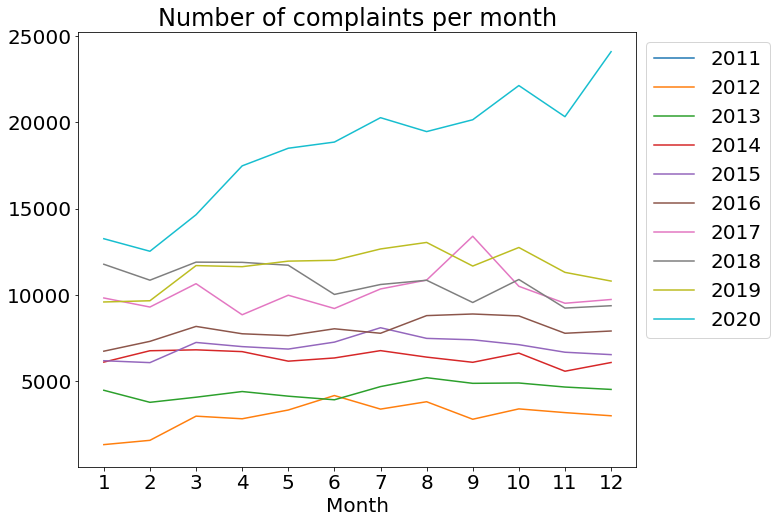

In [5]:
#plot number of complaints per month - one line plot for each yar
for year in range(2011, 2021):
    plt.plot(df[df['year'] == year]['month'].value_counts().sort_index(), label=str(year))

plt.title('Number of complaints per month')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

It seems that 2020 has a completely different monthly distribution of complaints compared to previous years!

In previous years, the number of complaints is approximately constant, or at least doesn't vary much from month to month. The one major exception is September 2017 (the peak in the pink line). We will come back to that.

However, in 2020, the number of complaints grows higher and higher as the year goes on. Especially between February and April, there is a particularly sharp rise.

# Let's get some insight into what the complaints look like.

## 1. What issues are consumers complaining about most? 
Answer: By far the most common complaint is "Incorrect information on your report."

In [6]:
#list the top few "issues" that get complained about
df['Issue'].value_counts().head(10)

Incorrect information on your report                                                240006
Problem with a credit reporting company's investigation into an existing problem     95572
Loan modification,collection,foreclosure                                             56328
Attempts to collect debt not owed                                                    51761
Incorrect information on credit report                                               51263
Loan servicing, payments, escrow account                                             38564
Improper use of your report                                                          34051
Cont'd attempts collect debt not owed                                                30417
Managing an account                                                                  29671
Written notification about debt                                                      25232
Name: Issue, dtype: int64

## 2. What companies are receiving the most complaints?
Answer: There are 3 major standouts, and these are precisely the 3 national credit report agencies. (Equifax, Transunion, and Experian)

In [7]:
#list the top few companies that receive the largest volume of complaints
df['Company'].value_counts().head(10)

EQUIFAX, INC.                             145566
TRANSUNION INTERMEDIATE HOLDINGS, INC.    122883
Experian Information Solutions Inc.       118275
BANK OF AMERICA, NATIONAL ASSOCIATION      51476
WELLS FARGO & COMPANY                      43556
JPMORGAN CHASE & CO.                       39787
CITIBANK, N.A.                             33337
CAPITAL ONE FINANCIAL CORPORATION          27737
Navient Solutions, LLC.                    17255
SYNCHRONY FINANCIAL                        16264
Name: Company, dtype: int64

# Let's dig deeper. 
We will retain the names of the 3 credit report agencies, and lump all other companies into an "Other" category.

In [8]:
# get list containing names of the 3 national credit report agencies.
cr_agencies = df['Company'].value_counts()[:3].index.tolist()
print(cr_agencies)

['EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'Experian Information Solutions Inc.']


In [9]:
# define and apply a function to the dataframe that simplifies the company name
def simplify_company(x):
    if x in cr_agencies:
        return x.split()[0].capitalize().replace(',','' )
    else:
        return 'Other'
    
df['simplified_company'] = df['Company'].apply(simplify_company)

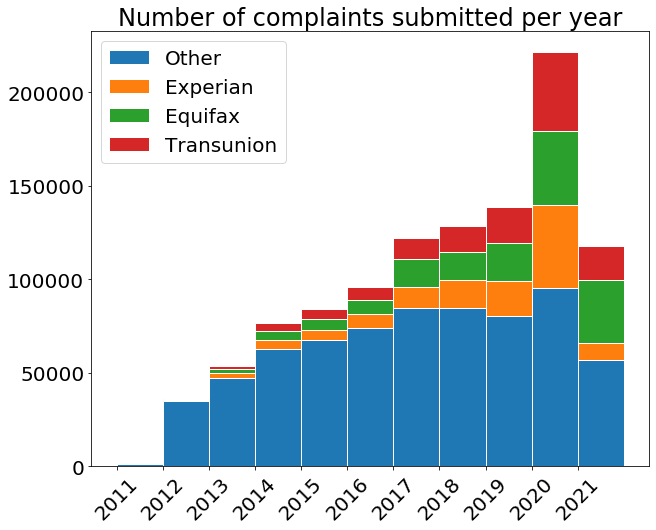

In [15]:
#plot complaints by company

companies = df['simplified_company'].unique()

complaints_by_company = []

for company in companies:
    complaints_by_company.append(df[df['simplified_company'] == company])

plt.hist([company['year'] for i, company in enumerate(complaints_by_company)], 
         label = companies, bins=list(range(2011,2023,1)), edgecolor='white', stacked=True)

plt.title('Number of complaints submitted per year')
plt.xticks(list(range(2011,2022,1)), rotation=45)
plt.legend()
plt.show()

We can see that the "Other" category only grows slightly from 2019 to 2020. However, each of the credit report agency categories grows hugely, approximately doubling in volume! Could the change in complaints filed against just these 3 specific companies account for the overall shift in monthly distribution of complaints in 2020?

Note: the ability to submit reports against credit bureaus to CFPB only became available in October 2012, so the 2011 and 2012 data here is not necessarily meaningful.

To answer this, let's take another look by month.

This time, we'll simplify the company name even futher, marking it 'True' if the company is one of the 3 national credit report agencies, and 'False' otherwise.

In [11]:
# define and apply a function to the dataframe that decides 
# whether the company is one of the credit report agencies or not.
def is_cr_agency(x):
    if x in cr_agencies:
        return True
    else:
        return False
    
df['is_cr_agency'] = df['Company'].apply(is_cr_agency)

In [12]:
# define a new data frame containing only data for the credit report agencies
df_cr = df[df['is_cr_agency'] == True]

# define a new data frame containing only data for companies OTHER THAN the credit report agencies
df_not_cr = df[df['is_cr_agency'] == False]

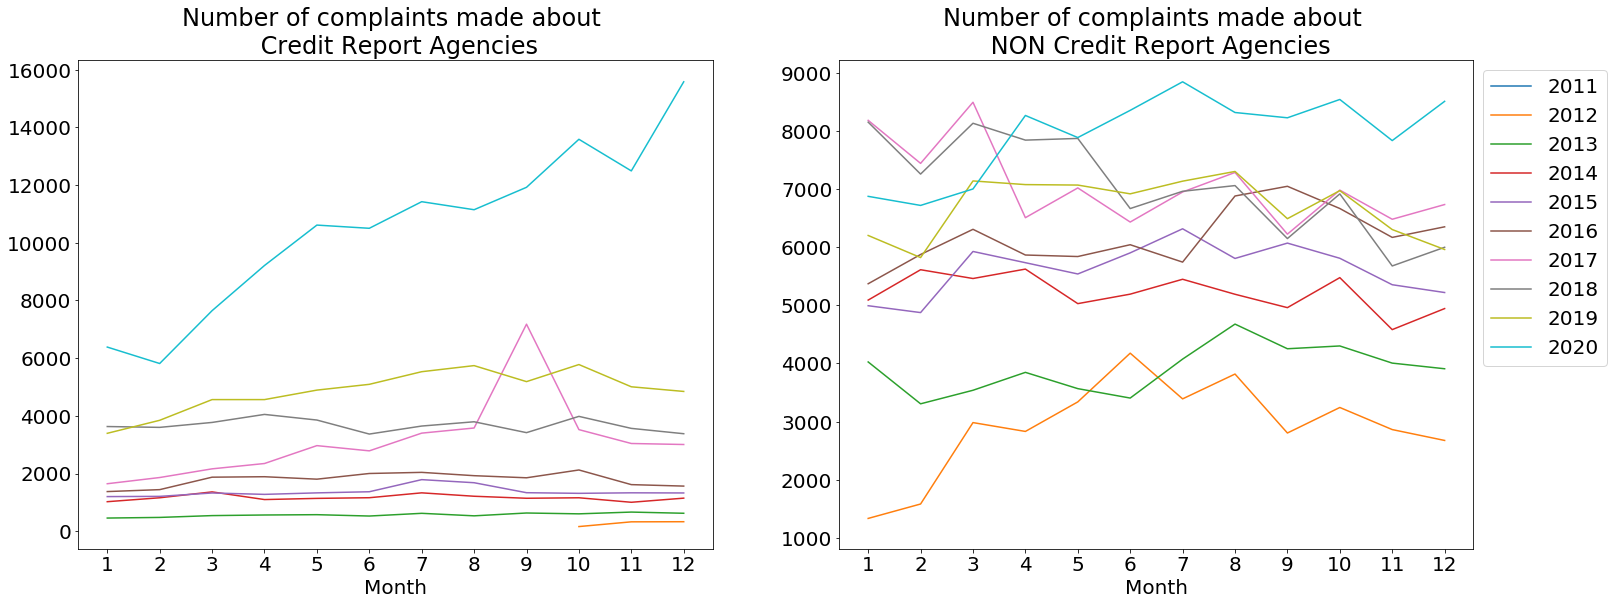

In [13]:
plt.figure(figsize=(25,9))

plt.subplot(121)
# make monthly plot again, but this time ONLY including complaints made to one of the credit reporting agencies.
for year in range(2011, 2021):
    plt.plot(df_cr[df_cr['year'] == year]['month'].value_counts().sort_index())


plt.title('Number of complaints made about \n Credit Report Agencies')
plt.xlabel('Month')
plt.xticks(range(1,13))



# make monthly plot again, but this time ONLY including complaints NOT made to one of the credit reporting agencies.
plt.subplot(122)

for year in range(2011, 2021):
    plt.plot(df_not_cr[df_not_cr['year'] == year]['month'].value_counts().sort_index(), label=str(year))


plt.title('Number of complaints made about \n NON Credit Report Agencies')
plt.xlabel('Month')
plt.xticks(range(1,13))
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

We can see that the overall trends are almost entirely accounted for by the first plot, while the second plot pretty much just adds some constant noise. (There is still a general trend of increasing number of reports being submitted over time, but this can be explained simply by the use of CFPB reports becoming more well known and popular over time.)

# So what happened in 2020?

On April 20, 2020, the FTC announced that all three major credit reporting agencies would now be providing free weekly credit scores to everyone, due to the COVID-19 pandemic. Previously, you could only get one free credit score per 12 months per agency.

More credit score reports being requested and received -> more complaints of inaccuracies on credit score reports.

However, that was April. Recall that we start seeing an uptick in the number of complaints as early as March. So what's the explanation for that? Well, March was when the country started going into lockdown (California was the first state to issue a stay-at-home order, on March 19, 2020.) Because of the immediate impact on employment and financial security, people started requesting credit scores at an increased rate beginning in March.

Finally, what's up with the weird spike in the pink curve? In September 2017, Equifax announced a massive data breach that compromised millions of people's personal information.

Taking a look at 2017 company breakdown per month, we can see that the spike in September 2017 is entirely due to increased complaints against Equifax:

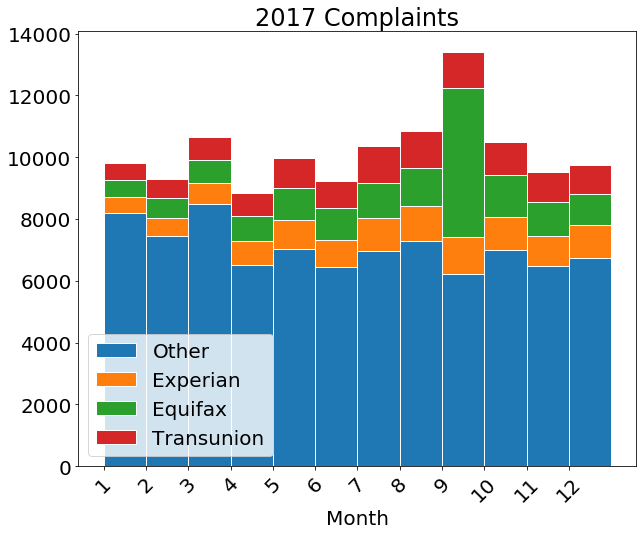

In [33]:
df_2017 = df[df['year']==2017]

complaints_by_company_2017 = []

for company in companies:
    complaints_by_company_2017.append(df_2017[df_2017['simplified_company'] == company])

plt.hist([company['month'].astype('int64') for i, company in enumerate(complaints_by_company_2017)], 
         label = companies, bins=list(range(1,14,1)), edgecolor='white', stacked=True)

plt.title('2017 Complaints')
plt.xticks(list(range(1,13,1)), rotation=45)
plt.xlabel('Month')
plt.legend(loc='lower left')
plt.show()
plt.show()